In [1]:
# Importando o framework para predição das imagens
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
# Importando bibliotecas para analises de imagens
import cv2
import imgaug as im # data augmentation mas sera usado somente para mostrar imagens
from PIL import Image

# Importando bibliotecas do sistema
import os
import base64

# Importa biblioteca para rede neural
import keras
import segmentation_models as sm

# Importa bibliotecas para analise de dados
import pandas as pd
import numpy as np

# Importa bibliotecas para visualização de dataframes com imagens
import pdfkit as pdf
from io import BytesIO
from IPython.display import HTML


Segmentation Models: using `tf.keras` framework.


In [3]:
path_name_image = './../../wvc2021/jupiter_notebooks/img_generated/img_original/'

model = sm.Linknet('vgg16', encoder_weights='imagenet')
model_2 = sm.Linknet('vgg16', encoder_weights='imagenet')
model_3 = sm.Linknet('vgg16', encoder_weights='imagenet')

model.load_weights('../neural_network/supervisionated/diverses_backbones/segment_weed_2.h5')
model_2.load_weights('../neural_network/supervisionated/marcacoes_externas/vgg16_Linknet_2.hdf5')
model_3.load_weights('../neural_network/supervisionated/marcacoes_filtro_verde/vgg16_Linknet_Test13.hdf5')


In [4]:
count = 0
name_model = ['model','model_2', 'model_3']
dir_save = ['pred_0/','pred_1/', 'pred_2/']

save_dir = './../../wvc2021/jupiter_notebooks/img_generated/imgs_pred/'


In [ ]:

for name_image in os.listdir(path_name_image):
    count += 1
    #if count > 3:
    #    break
        
    image_rgb = cv2.imread(path_name_image + name_image)
    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB) / 255
    predictions = []
    
    for i in range(3): 
        #print(name_model[i])
        image = image_rgb.copy()
        pred = eval(str(name_model[i]) + '.predict(np.array([image_rgb]))[0]')
        pred = np.array(pred)
        pred = pred[:,:,0]

        pred[pred > 0.1] = 1
        pred[pred < 0.1] = 0
        
        image[pred == 1] = [255,0,0]
        image = image.astype('float32')
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = image * 255
        
        predictions.append(pred)
        
        cv2.imwrite(save_dir + dir_save[i] + name_image, image)
        
        del pred, image
       
    new_pred = np.array(predictions[0]) + np.array(predictions[1])+ np.array(predictions[2])
    print(new_pred.min(), new_pred.max())
    #new_pred = new_pred / (3)
    new_pred[new_pred < 1 ] = 0
    new_pred[new_pred >= 1] = 1
    
    #im.imshow(new_pred)
    image = image_rgb.astype('float32')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image[new_pred == 1] = [0,0,255]
    image = image * 255    
    
    cv2.imwrite(save_dir + 'pred_total_all/' + name_image, image)

In [6]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [10]:
dict_predict_images = {}
name_collums = ['path_imgs','path_model', 'path_model_2', 'path_model_3', 'path_model_partial', 'path_total']

dir_images = './../../wvc2021/jupiter_notebooks/img_generated/img_original/'

path_model = './../../wvc2021/jupiter_notebooks/img_generated/imgs_pred/pred_0/'
path_model_2 = './../../wvc2021/jupiter_notebooks/img_generated/imgs_pred/pred_1/'
path_model_3 = './../../wvc2021/jupiter_notebooks/img_generated/imgs_pred/pred_2/'
path_model_partial = './../../wvc2021/jupiter_notebooks/img_generated/imgs_pred/pred_total_0_33/'
path_model_total = './../../wvc2021/jupiter_notebooks/img_generated/imgs_pred/pred_total_all/'

In [16]:
for i in range(len(name_collums)):
    dict_predict_images[name_collums[i]] = []

In [17]:
for name_image in os.listdir(path_name_image):
    dict_predict_images['path_imgs'].append(str(dir_images) + str(name_image))
    dict_predict_images['path_model'].append(str(path_model) + str(name_image))
    dict_predict_images['path_model_2'].append(str(path_model_2) + str(name_image))
    dict_predict_images['path_model_3'].append(str(path_model_3) + str(name_image))
    dict_predict_images['path_model_partial'].append(str(path_model_partial) + str(name_image))
    dict_predict_images['path_total'].append(str(path_model_total) + str(name_image))

In [13]:
df = pd.DataFrame(dict_predict_images)

In [18]:
df['imgs'] = df.path_imgs.map(lambda f: get_thumbnail(f))
df['model'] = df.path_model.map(lambda f: get_thumbnail(f))
df['model_2'] = df.path_model_2.map(lambda f: get_thumbnail(f))
df['model_3'] = df.path_model_3.map(lambda f: get_thumbnail(f))
df['votation'] = df.path_model_3.map(lambda f: get_thumbnail(f))
df['model_total'] = df.path_total.map(lambda f: get_thumbnail(f))

,imgs,model,model_2,model_3,model_total
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,
5,,,,,
6,,,,,
7,,,,,
8,,,,,
9,,,,,

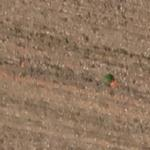
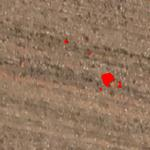
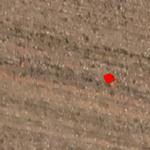
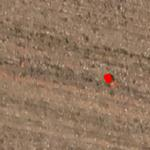
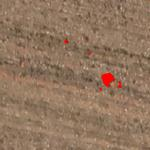
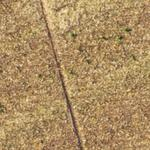
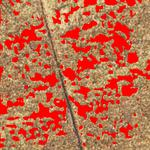
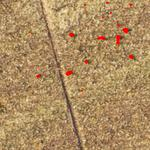
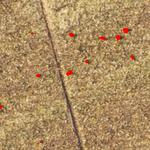
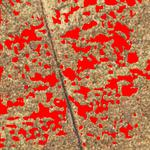
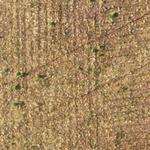
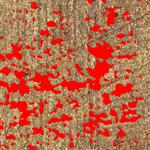
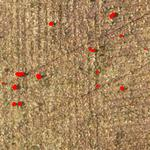
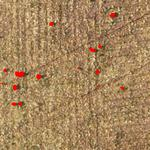
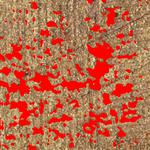
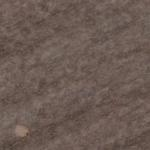
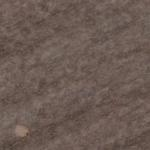
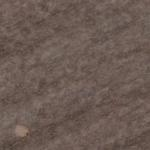
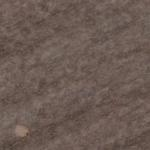
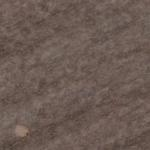
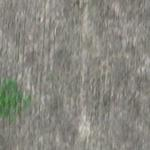
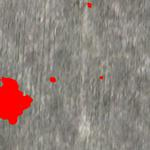
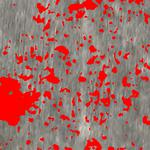
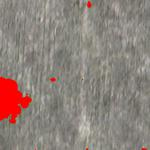
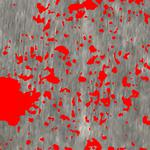
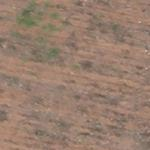
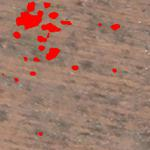
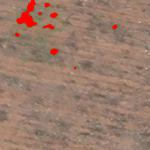
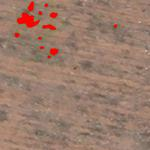
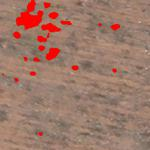
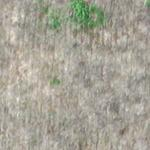
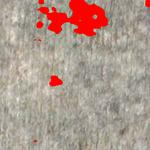
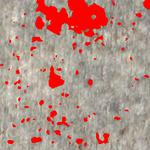
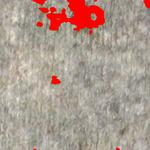
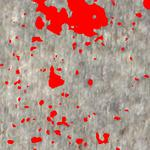
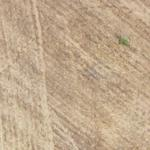
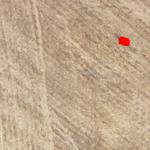
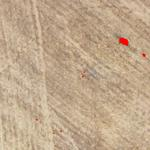
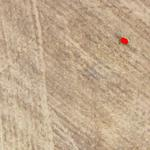
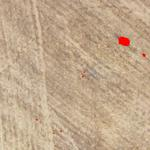
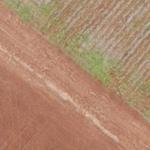
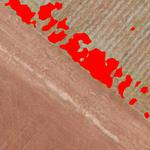
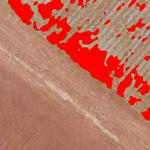
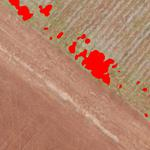
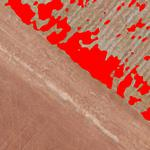
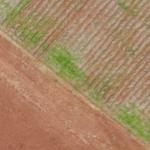
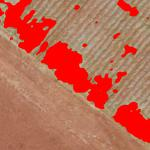
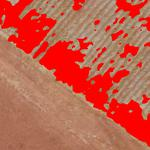
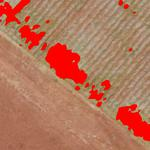
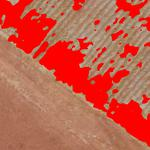
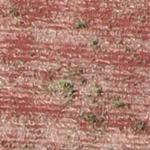
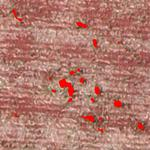
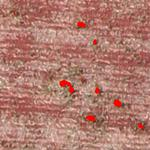
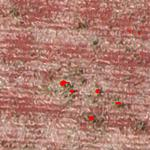
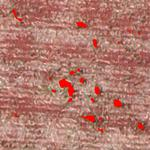
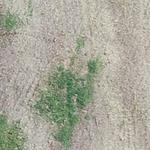
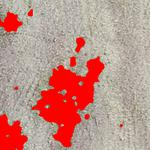
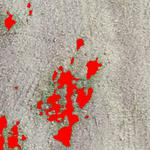
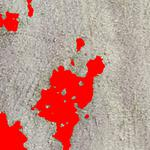
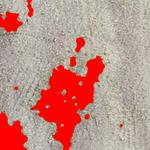
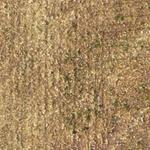
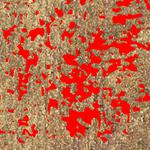
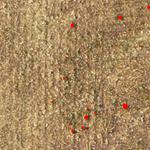
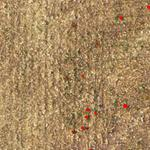
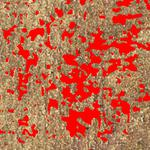
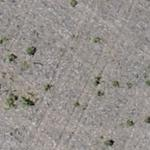
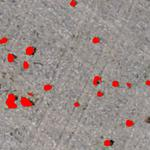
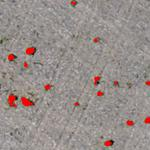
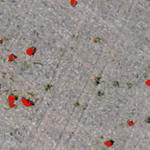
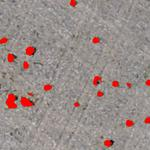
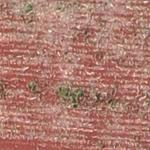
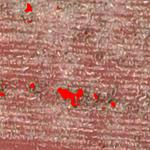
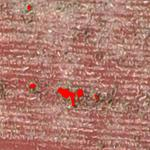
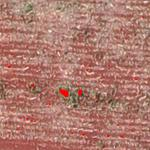
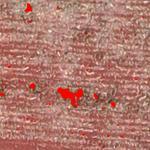
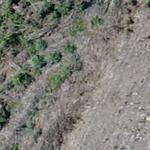
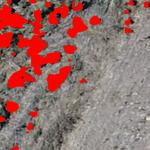
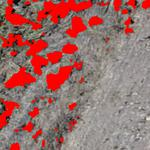
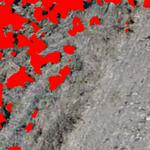
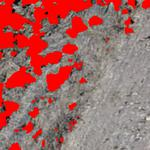
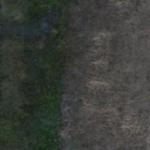
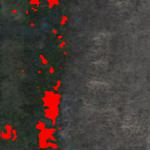
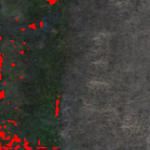
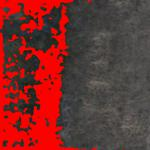
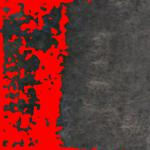
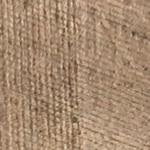
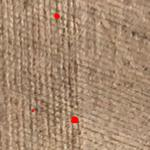
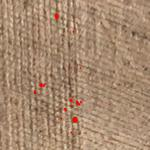
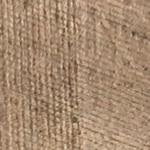
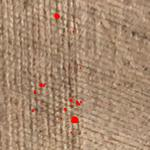
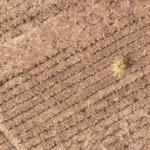
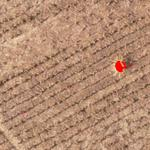
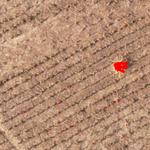
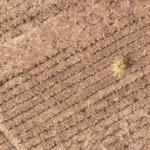
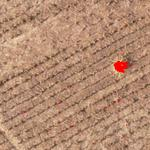
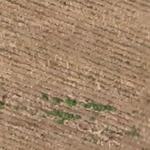
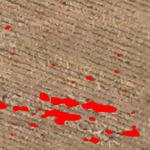
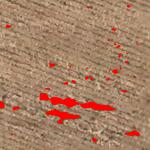
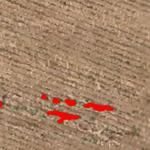
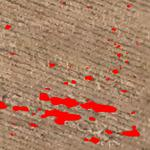
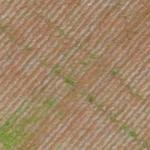
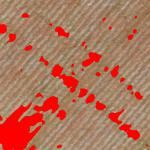
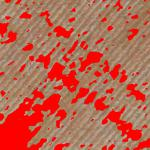
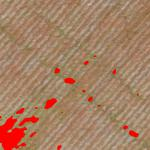
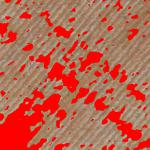
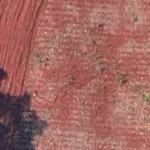
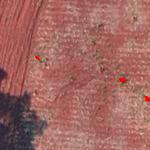
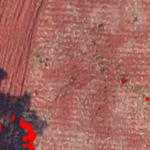
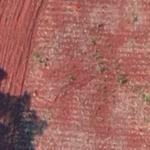
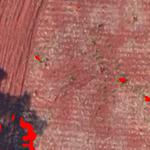
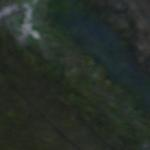
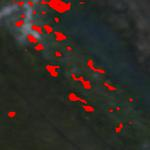
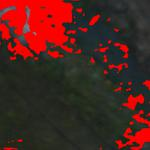
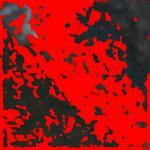
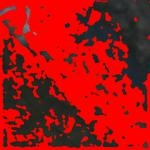
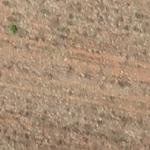
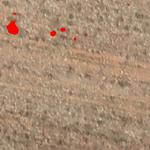
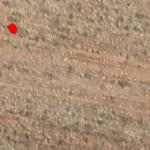
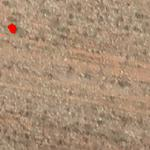
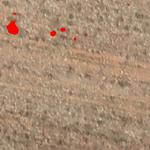
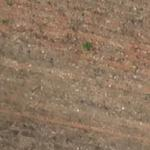
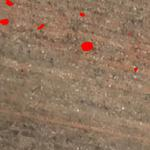
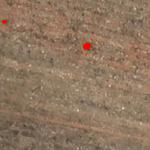
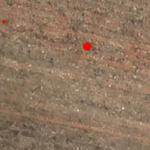
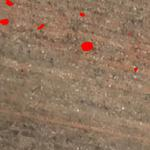
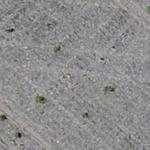
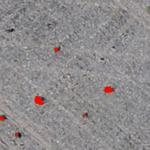
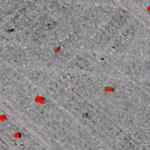
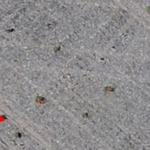
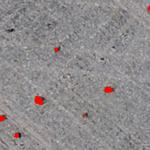

In [24]:
table = HTML(df[['imgs', 
                 'model', 
                 'model_2', 
                 'model_3', 
                 'model_total']].to_html(#'table.html', 
                                         formatters={'imgs': image_formatter,
                                         'model': image_formatter,
                                         'model_2': image_formatter,
                                         'model_3': image_formatter, 
                                         'model_total': image_formatter},
                                         escape=False))

#pdf.from_file('table.html', 'table.pdf')
table